In [20]:
num_figure = 0 ; num_table = 0 # initialize counters

<style>
.text_cell_render {
font-family: Times New Roman, serif;
}
</style>

# <center> DS745: Project Three<center>

<center>John Woodward<center>
    
    

<center>2023-10-31<center>


<div style="page-break-after: always;"></div>

In [21]:
# reading data
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point

def filter_states(row):
    states_to_ignore = ['AK', 'DC', 'HI', 'PR', 'US']
    return row['State'] not in states_to_ignore

data = pd.read_csv('50states.txt', 
                   sep=',', 
                   header=None, 
                   names=['State', 'Latitude', 'Longitude'])

data = data[data.apply(filter_states, axis=1)]
data.reset_index(drop=True, inplace=True)
#data

In [22]:
data

,State,Latitude,Longitude
0,AL,32.361538,-86.279118
1,AZ,33.448457,-112.073844
2,AR,34.736009,-92.331122
3,CA,38.555605,-121.468926
4,CO,39.739167,-104.984167
5,CT,41.767000,-72.677000
6,DE,39.161921,-75.526755
7,FL,30.451800,-84.272770
8,GA,33.760000,-84.390000
9,ID,43.613739,-116.237651


In [23]:
import math

# Number of edges (E)
num_edges = lambda N: math.ceil(N * (N - 1) / 2)

# Number of tour possibilities (T)
num_tour_combinations = lambda N: int(math.factorial(N-1)/2) if N <= 8 else f"{math.factorial(N-1)/2:.1e}"

print(num_edges(48))
print(num_tour_combinations(48))

1128
1.3e+59


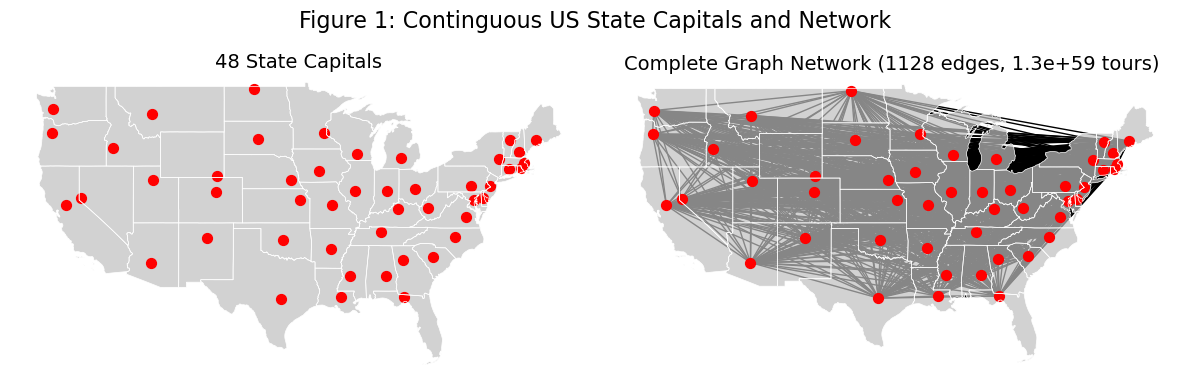

In [24]:


# Filter out Alaska & Hawaii
def filter_contiguous_states(geodataframe, data):
    return geodataframe[geodataframe['STUSPS'].isin(data['State'])]

# Create NetworkX graph for capitals
def create_state_capitals_graph(data):
    G = nx.Graph()
    for i, row in data.iterrows():
        G.add_node(row['State'], pos=(row['Longitude'], row['Latitude']), label=row['State'])
    return G


def create_map_subplot(geodataframe, ax):
    geodataframe.boundary.plot(ax=ax, 
                               linewidth=0.5, 
                               color='white')  # State boundaries
    geodataframe.plot(ax=ax, 
                      color='silver', 
                      alpha=0.7)  # Filled states



# NetworkX graphs
def plot_network_graph(G, node_positions, ax, with_labels = False, width=1):
    nx.draw(G, 
            pos=node_positions, 
            node_size=50, 
            font_size=12, 
            node_color='red', 
            edge_color='black', 
            with_labels=with_labels, 
            ax=ax,
            verticalalignment='bottom',
            width=width)

def create_complete_graph(data):
    G_complete = nx.complete_graph(len(data))
    node_names = {i: 
                  state for i, state in enumerate(data['State'])}
    G_complete = nx.relabel_nodes(G_complete, 
                                  node_names)
    node_positions_complete = {node: 
                               (data.at[i, 'Longitude'], data.at[i, 'Latitude']) for i, node in data['State'].items()}
    nx.set_node_attributes(G_complete, 
                           node_positions_complete, 
                           'pos')
    return G_complete

# Load shapefile
usa = gpd.read_file('cb_2014_us_state_20m.shp')

# Filter out Alaska & Hawaii
usa_contiguous = filter_contiguous_states(usa, data)

# Create subplots with reduced vertical space
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Create NetworkX graph
G = create_state_capitals_graph(data)
node_positions = {node: (data.at[i, 'Longitude'], data.at[i, 'Latitude']) for i, node in data['State'].items()}

# Plot NetworkX graph in first subplot
plot_network_graph(G, node_positions, axes[0])

# Create map subplot in first subplot
create_map_subplot(usa_contiguous, axes[0])

# Create complete graph
G_complete = create_complete_graph(data)

# Plot complete graph in second subplot
plot_network_graph(G_complete, nx.get_node_attributes(G_complete, 'pos'), axes[1])

# Create map subplot in second subplot
create_map_subplot(usa_contiguous, axes[1])

# Set titles
num_figure = 1
plt.suptitle(f'Figure {num_figure}: Continguous US State Capitals and Network', fontsize=16)
axes[0].set_title('48 State Capitals', fontsize=14)
axes[1].set_title(f'Complete Graph Network ({num_edges(48)} edges, {num_tour_combinations(48)} tours)', fontsize=14)
# Set y-limits for the first subplot
axes[0].set_ylim([24.5, 50])

# Set y-limits for the second subplot
axes[1].set_ylim([24.5, 50])

# Adjust subplot spacing
plt.tight_layout() 

# Show the subplots
plt.show()


Follow others examples:

https://medium.com/analytics-vidhya/model-and-solution-of-the-traveling-salesman-problem-with-python-and-pyomo-db45f2631e8c

Might want to start small with his example or a small example I find online. Smaller is better starting out!!!!

It doesn't matter if it isn't latitude and longitude to start for the distance matrix formulation

In [25]:
import pandas as pd
import numpy as np
from geopy.distance import great_circle

def calculate_distance_matrix(states, latitudes, longitudes):
    num_states = len(states)
    distances = np.zeros((num_states, num_states), dtype=int) # initialize

    for i in range(num_states):
        for j in range(num_states):
            if i == j:
                distances[i][j] = 0
            else:
                coord1 = (latitudes[i], longitudes[i])
                coord2 = (latitudes[j], longitudes[j])
                dist = round(great_circle(coord1, coord2).miles) # want it to be rounded up
                distances[i][j] = dist

    distance_matrix = pd.DataFrame(distances, index=states, columns=states)
    return distance_matrix

# Example usage:
states = data['State'].values
latitudes = data['Latitude'].values
longitudes = data['Longitude'].values
distance_matrix = calculate_distance_matrix(states, latitudes, longitudes)
distance_matrix

,AL,AZ,AR,CA,CO,CT,DE,FL,GA,ID,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
AL,0,1494,385,2013,1159,990,763,177,146,1794,...,1123,264,692,1528,1105,614,2168,489,759,1188
AZ,1494,0,1131,632,586,2211,2059,1638,1588,737,...,982,1443,868,505,2228,1956,1097,1729,1393,665
AR,385,1131,0,1630,776,1168,975,554,458,1413,...,790,327,442,1144,1237,851,1793,644,597,810
CA,2013,632,1630,0,886,2551,2445,2175,2081,443,...,1162,1901,1463,531,2526,2372,591,2138,1696,901
CO,1159,586,776,886,0,1687,1565,1331,1209,639,...,399,1020,771,371,1682,1487,1028,1253,839,98
CT,990,2211,1168,2551,1687,0,234,1013,844,2190,...,1401,849,1602,2020,173,387,2462,529,856,1654
DE,763,2059,975,2445,1565,234,0,779,617,2111,...,1322,649,1399,1915,384,153,2412,334,769,1545
FL,177,1638,554,2175,1331,1013,779,0,229,1967,...,1300,420,803,1698,1148,626,2343,566,916,1362
GA,146,1588,458,2081,1209,844,617,229,0,1834,...,1123,214,818,1580,962,468,2196,352,698,1226
ID,1794,737,1413,443,639,2190,2111,1967,1834,0,...,791,1634,1370,297,2147,2058,401,1827,1344,607


In [26]:
import numpy as np

# subset of states (New england box)
subset_states = data[data['Longitude'] > -74]['State'].values

# Pandas indexing
distance_matrix_subset = distance_matrix.loc[subset_states, subset_states]

cost_matrix = distance_matrix_subset.values # numpy array
n = len(cost_matrix) # for the number of cities

distance_matrix_subset

,CT,ME,MA,NH,NY,RI,VT
CT,0,230,91,116,84,65,173
ME,230,0,158,117,232,192,139
MA,91,158,0,73,143,35,160
NH,116,117,73,0,119,97,89
NY,84,232,143,119,0,134,126
RI,65,192,35,97,134,0,178
VT,173,139,160,89,126,178,0


In [27]:
import numpy as np

def create_travel_matrix(tour_edges, city_names):
    n = len(city_names)
    travel_matrix = np.zeros((n, n), dtype=int)
    
    city_indices = {city: i for i, city in enumerate(city_names)}
    
    for edge in tour_edges:
        i, j = city_indices[edge[0]], city_indices[edge[1]]
        travel_matrix[i, j] = 1
    
    return travel_matrix

calculate_total_cost = lambda travel_matrix, distance_matrix: np.sum(travel_matrix * distance_matrix)

# Example usage:
city_names = distance_matrix_subset.columns.to_list()
tour_edges = [('CT', 'RI'), ('RI', 'MA'), ('MA', 'NH'), ('NH', 'ME'), ('ME', 'VT'), ('VT', 'NY'), ('NY', 'CT')]
total_cost = calculate_total_cost(travel_matrix = create_travel_matrix(tour_edges, city_names), 
                                  distance_matrix = distance_matrix_subset.values)
#print(f'{total_cost} miles')

In [28]:
# # Create integer array
# x_values = np.array([[int(model.x[i, j]()) for j in model.N] for i in model.N])

# # Create Pandas DataFrame
# x_df = pd.DataFrame(x_values, 
#                     index=model.N, 
#                     columns=model.N)

# # Output the DataFrame with from and to column names
# x_df.columns = distance_matrix_subset.columns
# x_df.index = distance_matrix_subset.index

# # Print the DataFrame
# print(x_df)


In [53]:
import pyomo.environ as pyo
import time  # Import the time module
import multiprocessing # processor count

class TSPSolver:
    def __init__(self, cost_matrix, 
                 column_names=None, 
                 pre_solved_subtours=None
                ):
        self.cost_matrix = cost_matrix
        self.column_names = column_names
        self.pre_solved_subtours = pre_solved_subtours
        self.model = None
        self.result = None

    def create_model(self, subtour_constraints=True):
        # Create a concrete Pyomo model
        self.model = pyo.ConcreteModel()

        # Define the city indexes (square)
        n = len(self.cost_matrix)
        self.model.N = pyo.RangeSet(n)

        # Dummy variable u (sequence)
        self.model.U = pyo.RangeSet(2, n)

        # Decision variables xij (Cities to visit)
        self.model.x = pyo.Var(self.model.N, 
                               self.model.N, 
                               within=pyo.Binary)

        # Dummy variable ui
        self.model.u = pyo.Var(self.model.N, 
                               within=pyo.NonNegativeIntegers, 
                               bounds=(0, n - 1))

        # Define the cost matrix cij
        self.model.c = pyo.Param(self.model.N, 
                                 self.model.N, 
                                 initialize=lambda model, i, j: self.cost_matrix[i - 1][j - 1])

        # Define the objective function
        def objective_rule(model):
            return sum(model.x[i, j] * model.c[i, j] for i in model.N for j in model.N)

        self.model.objective = pyo.Objective(rule=objective_rule, 
                                             sense=pyo.minimize)

        # Define constraints            
        def constraint1_rule(model, N):
            return sum(model.x[i, N] for i in model.N if i != N) == 1

        self.model.const1 = pyo.Constraint(self.model.N, 
                                           rule=constraint1_rule)

        def constraint2_rule(model, N):
            return sum(model.x[N, j] for j in model.N if j != N) == 1

        self.model.const2 = pyo.Constraint(self.model.N, 
                                           rule=constraint2_rule)

        def constraint3_rule(model, i):
            return model.x[i, i] == 0

        self.model.const3 = pyo.Constraint(self.model.N, 
                                           rule=constraint3_rule)

        # Subtour constraints
        def constraint4_rule(model, i, j):
            if i != j:
                return model.u[i] - model.u[j] + model.x[i, j] * n <= n - 1
            else:
                return pyo.Constraint.Skip

        if subtour_constraints:
            self.model.const4 = pyo.Constraint(self.model.U, 
                                               self.model.N, 
                                               rule=constraint4_rule)

        # Pre-solved subtour constraints
        def constraint5_rule(model, i, j):
            constraints = []
            if self.pre_solved_subtours:
                for subtour in self.pre_solved_subtours:
                    if len(subtour) > 1:
                        constraint_expr = sum(model.x[i, j] for i, j in zip(subtour, subtour[1:])) == len(subtour) - 1 # [a,b,c] goes x[a,b] + x[b,c] == 3 - 1
                        constraints.append(constraint_expr)
            return constraints

        if self.pre_solved_subtours:
            self.model.const5 = pyo.ConstraintList()
            for i, constraint_expr in enumerate(constraint5_rule(self.model, None, None)):
                self.model.const5.add(constraint_expr)
        

    def find_subtours(self):
        subtours = []
        remaining_cities = list(self.model.N)

        while remaining_cities:
            current_city = remaining_cities[0]
            subtour = [current_city]

            while True:
                next_city = next(j for j in self.model.N if self.model.x[current_city, j]() > 0)
                if next_city == subtour[0]:
                    break
                subtour.append(next_city)
                remaining_cities.remove(next_city)
                current_city = next_city

            if len(subtour) > 1:
                subtours.append(subtour)

            remaining_cities = [city for city in remaining_cities if city not in subtour]

        # Convert subtours to strings with column names
        if self.column_names:
            subtour_strings = ['-'.join(self.column_names[i - 1] for i in subtour) for subtour in subtours]
        else:
            subtour_strings = ['-'.join(map(str, subtour)) for subtour in subtours]

        return subtour_strings

    
    def solve(self, 
              subtour_constraints=True, 
              verbose=True, 
              num_threads=multiprocessing.cpu_count() # Get the number of available processors
             ): 
        start_time = time.time()
        
        self.create_model(subtour_constraints)

        # Specify the path to the cbc solver executable
        cbc_solver_path = 'C:\\Users\\John W\\anaconda3\\Library\\bin\\cbc.exe'

        # Solve the model using MILP solver
        solver = pyo.SolverFactory('cbc', 
                                   executable=cbc_solver_path, 
                                   options={'threads': num_threads})  # use the number of processors available for multithreading (helps greatly during branch and bound tree searches)
           
        self.result = solver.solve(self.model, tee=verbose)
        
        # print Decision Variables? 
        if verbose:
            print("Decision Variables:")
            for i in self.model.N:
                u_i = int(self.model.u[i].value)
                print(f"u[{i}] = {u_i}")
                for j in self.model.N:
                    if i != j and int(self.model.x[i, j].value) != 0:
                        x_ij = int(self.model.x[i, j].value)
                        print(f"x[{i},{j}] = {x_ij}")

        
        end_time = time.time()
        self.solution_time = round(end_time - start_time,2)  # Calculate the solution time

    def get_solution(self):
        if self.result is None:
            raise Exception("You need to call solve() before getting the solution.")

        # Find subtours in the solution
        subtours = self.find_subtours()

        # Round the objective value to the nearest integer
        rounded_objective = round(pyo.value(self.model.objective))

        solution = {
            "status": self.result.solver.status,
            "objective_value": rounded_objective,
            "decision_variables": self.model.x,
            "subtours": subtours,
            "solution_time": self.solution_time  # Add solution time to the result
        }

        return solution


In [54]:
tsp_solver = TSPSolver(cost_matrix)
tsp_solver.solve(subtour_constraints=False, verbose=False)
solution = tsp_solver.get_solution()

# Access results
print(f"SolveTime: {solution['solution_time']} ms")
print(f"Status: {solution['status']}")
print(f"Objective Value: {solution['objective_value']} miles")
print(f"Subtours: {solution['subtours']}")

SolveTime: 0.14 ms
Status: ok
Objective Value: 583 miles
Subtours: ['1-5', '2-4-7', '3-6']


In [57]:
tsp_solver = TSPSolver(cost_matrix)
tsp_solver.solve(subtour_constraints=True, verbose=False, num_threads=1)
solution = tsp_solver.get_solution()

# Access results
print(f"SolveTime: {solution['solution_time']} ms")
print(f"Status: {solution['status']}")
print(f"Objective Value: {solution['objective_value']} miles")
print(f"Subtours: {solution['subtours']}")

SolveTime: 0.84 ms
Status: ok
Objective Value: 639 miles
Subtours: ['1-6-3-4-2-7-5']


In [44]:
distance_matrix_subset.columns.tolist()

['CT', 'ME', 'MA', 'NH', 'NY', 'RI', 'VT']

In [59]:
# Define your pre-solved tour(s) (if any)
pre_solved_subtours = [[1, 6, 3 , 4 , 2, 7]]  # List of subtours

# Create the TSPSolver instance with the cost matrix and pre-solved subtours
tsp_solver = TSPSolver(cost_matrix
                       ,column_names= distance_matrix_subset.columns.tolist()
                       #,pre_solved_subtours=pre_solved_subtours
                      )

# Solve the TSP problem with subtour constraints and suppress verbosity
tsp_solver.solve(subtour_constraints=True, verbose=False)

# Access the solution
solution = tsp_solver.get_solution()

# Print the results
print(f"SolveTime: {solution['solution_time']} ms")
print(f"Status: {solution['status']}")
print(f"Objective Value: {solution['objective_value']} miles")
print(f"Subtours: {solution['subtours']}")


SolveTime: 0.83 ms
Status: ok
Objective Value: 639 miles
Subtours: ['CT-RI-MA-NH-ME-VT-NY']


In [46]:
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! (doesnt work)

["'!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!' is not recognized as an internal or external command,",
 'operable program or batch file.']

In [60]:
def convert_city_names_to_indices(city_names, cost_matrix):
    # Create a mapping of city names to city indices
    city_name_to_index = {city_name: index for index, city_name in enumerate(cost_matrix.index)}
    
    # Convert city names to indices
    city_indices = [city_name_to_index[city_name]+1 for city_name in city_names.split('-')]
    
    return city_indices

# Example usage:
city_names = 'CT-RI-MA-NH-ME-VT-NY'  # Replace with the actual list of city names
pre_solved_subtours = [convert_city_names_to_indices(city_names, distance_matrix)]
print(pre_solved_subtours)


[[6, 37, 19, 27, 17, 43, 30]]


In [61]:
def tour_string_to_edges(tour_string):
    # Split the tour string
    tour_nodes = tour_string.split('-')
    # Generate tour edges
    tour_edges = [(tour_nodes[i], tour_nodes[i + 1]) for i in range(len(tour_nodes) - 1)]
    tour_edges.append((tour_nodes[-1], tour_nodes[0]))  # Connect last node to first node
    return tour_edges


In [62]:
tour_string_to_edges('CT-RI-MA-NH-ME-VT-NY')

[('CT', 'RI'),
 ('RI', 'MA'),
 ('MA', 'NH'),
 ('NH', 'ME'),
 ('ME', 'VT'),
 ('VT', 'NY'),
 ('NY', 'CT')]

KeyError: 'CT'

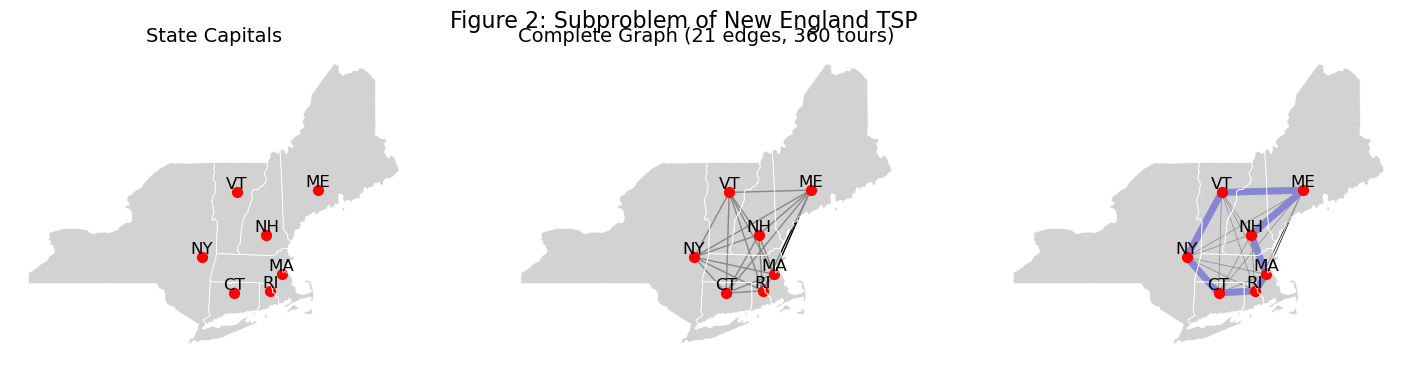

In [63]:
# Filter for New England States
ne_states = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT','NY']
data_ne = data[data['State'].isin(ne_states)]

# Filter out Alaska & Hawaii
usa_ne = filter_contiguous_states(usa, data_ne)

# Create NetworkX graph
G_ne = create_state_capitals_graph(data_ne)
node_positions_ne = {node: (data_ne.at[i, 'Longitude'], data_ne.at[i, 'Latitude']) for i, node in data_ne['State'].items()}

# Create complete graph
G_complete_ne = create_complete_graph(data_ne)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 4))  # Three subplots

# Plot NetworkX graph with labels
plot_network_graph(G_ne, node_positions_ne, axes[0], with_labels=True)
create_map_subplot(usa_ne, axes[0])

# Plot complete graph with labels
plot_network_graph(G_complete_ne, nx.get_node_attributes(G_complete_ne, 'pos'), axes[1], with_labels=True)
create_map_subplot(usa_ne, axes[1])

# Draw tour on the complete graph
tour_edges = tour_string_to_edges('CT-RI-MA-NH-ME-VT-NY') # what I estimate will be best tour
plot_network_graph(G_complete_ne, 
                   nx.get_node_attributes(G_complete_ne, 'pos'), 
                   axes[2], 
                   with_labels=True,
                  width=0.5)
nx.draw_networkx_edges(G_complete_ne, 
                       pos=nx.get_node_attributes(G_complete_ne, 'pos'), 
                       edgelist=tour_edges, 
                       ax=axes[2], 
                       edge_color='blue', 
                       width=5)
create_map_subplot(usa_ne, axes[2])

# titling
num_figure = 2
plt.suptitle(f'Figure {num_figure}: Subproblem of New England TSP', fontsize=16)
axes[0].set_title('State Capitals', fontsize=14)
axes[1].set_title(f'Complete Graph ({num_edges(7)} edges, {num_tour_combinations(7)} tours)', fontsize=14)
axes[2].set_title(f'Human-Estimated TSP Tour ({calculate_total_cost(travel_matrix = create_travel_matrix(tour_edges, city_names),distance_matrix = distance_matrix_subset.values)} miles)', fontsize=14) # calculated cost in miles

# Set limits of subplots
for ax in axes: # loop through all
    ax.set_ylim([41.5, 44.8])
    ax.set_xlim([-74.3, -68])

# Adjust subplot spacing to remove margins
plt.subplots_adjust(left=0.03, 
                    right=0.97,
                    top=0.8,
                    wspace=-0.5)

# Show the subplots
plt.show()


# Plan for the next session:

I want to get the solution time outputted in ms for solving the 48-state problem; then, I want to show how much simpler it is when you provide a subproblem solved for NE. (time)

Likewise, to minimize the time further to calculate, I want to show what happens when you initialize the starting city and pick one to ensure some stability in answers to break symmetry, such as starting with the NY first and then going the subtour to CT and then going everywhere else, afterward. 

Have two subplots below the three subplots:
one for LP with No Subtour Constraints
one for LP with Subtour Constraints

In [64]:
pre_solved_subtours

[[6, 37, 19, 27, 17, 43, 30]]

In [ ]:
# Define your pre-solved tour(s) (if any)

# Create the TSPSolver instance with the cost matrix and pre-solved subtours
tsp_solver = TSPSolver(distance_matrix.values
                       ,column_names= distance_matrix.columns.tolist()
                       ,pre_solved_subtours=pre_solved_subtours
                      )

# Solve the TSP problem with subtour constraints and suppress verbosity
tsp_solver.solve(subtour_constraints=True, verbose=False)

# Access the solution
solution = tsp_solver.get_solution()

# Print the results
print(f"SolveTime: {solution['solution_time']} ms")
print(f"Status: {solution['status']}")
print(f"Objective Value: {solution['objective_value']} miles")
print(f"Subtours: {solution['subtours']}")


In [336]:
distance_matrix.columns.tolist()

['AL',
 'AZ',
 'AR',
 'CA',
 'CO',
 'CT',
 'DE',
 'FL',
 'GA',
 'ID',
 'IL',
 'IN',
 'IA',
 'KS',
 'KY',
 'LA',
 'ME',
 'MD',
 'MA',
 'MI',
 'MN',
 'MS',
 'MO',
 'MT',
 'NE',
 'NV',
 'NH',
 'NJ',
 'NM',
 'NY',
 'NC',
 'ND',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VT',
 'VA',
 'WA',
 'WV',
 'WI',
 'WY']

<style>
.text_cell_render {
font-family: Times New Roman, serif;
}
</style>
## Porting `Python` from `R` Machine Learning Skills Assessment 

This project compares `R` and `Python` machine learning, replicating a skills assessment analysis with a one-week time constraint within a US Foods Data Scientist job interview. The question was: "Using Machine Learning - which US Foods customers will most likely opt for daily shipment service?" I initially tackled this in `R`, but afterward, the interviewers asked, "Why R?" Although my response was straightforward, "R was what I learned for machine learning, " I itched to explore a `Python` port afterward. Therefore, let's try `Python` next, and I can compare and contrast it. 

### Data Organization

The case study's dataset included two tables, with limited context from solely a data dictionary:

1. `survey_data_assessment` - a survey of various food service customers (primary key: CUST_NBR). Some duplicates are noticed, and these are not known to be helpful. Customers not surveyed are potential daily service delivery customers.
2. `transactional_data` - lower-level data, potentially from internal data queries, within customers with differing division numbers (primary key: CUST_NBR, DIV_NBR). Some duplicates are noticed, and these are not known to be helpful. 

### Selecting response and predictor variables
The survey data contains a smaller subset of US Foods' current customers who use the daily service to varying degrees. 

Because of this, collecting additional data columns from this survey was less meaningful. Therefore, to focus on the most relevant information, I solely used the survey data to select the response variable.

Predicting which customers spend the most with the US Foods Daily Delivery Service, as represented by the variable `REPORTED_WKLY_SPEND_USF_DAILY_SERVICE`, seemed to be the best measure of the service's success, as higher spending customers are considered the best service users. Thus, I chose this as my response variable.

Next, after joining the response variable with the larger dataset containing transactional data, I employed the remaining variables for independently predicting the survey response variable that is most effective for predicting daily service spending (i.e., `REPORTED_WKLY_SPEND_USF_DAILY_SERVICE`).

### Data Extraction, Loading, and Transforming (ETL)

Besides standard ETL work (e.g., extracting, removing duplicates, and whatnot), I ensured that NAs were properly captured for two variables, `MENU_TYP_DESC` and `PERC_EB.` For example, the menu type column has an "MT UNAVAILABLE," meaning menu-type-unavailable, and thus is an NA.

Another method I used was introducing two noise variables (e.g., `Random_*`). On one, I varied from 0 to 1 uniformly. On the other noise variable, I varied from 1 to 10 and varied how missing the information was. Although uncommon, using noise variables compared with other predictor variables helps differentiate signal from noise when assessing variable importance later.

Between `R` and `Python`, the data handling was slightly more intuitive using `R`. `R`'s `dplyr` library is very easy to use. But `Python`'s `pandas` library worked somewhat quickly, too. Conversely, with visualizations, `Python` was significantly more challenging to work with `matplotlib` rather than `R`'s `ggplot2` or `ggformula`. This isn't to say it was impossible; as Figure 1 shows, it looks as aesthetically pleasing as `R` once the time and effort were put in.

---------------------------------------------------

In [17]:
import pandas as pd
import random

random.seed(1)

# Read survey data
food_survey_raw = pd.read_excel("Survey Data Assessment Final.xlsx", 
                                sheet_name="survey_data_assessment")

# Select columns and remove duplicates
food_survey = food_survey_raw[['CUST_NBR', 
                               'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE']]
food_survey = food_survey.drop_duplicates(subset=['CUST_NBR'])

# Read transactional data
food_raw = pd.read_excel("Survey Data Assessment Final.xlsx", 
                         sheet_name="transactional_data")

# Handle missing values in MENU_TYP_DESC
food_raw['MENU_TYP_DESC'] = food_raw['MENU_TYP_DESC'].apply(lambda x: x if x != "MT UNAVAILABLE" else None)

# Remove duplicates in transactional data
food = food_raw.drop_duplicates(subset=['CUST_NBR', 
                                        'DIV_NBR'])

# Set a random seed
random.seed(1)

# Create a DataFrame DDS
DDS = food.merge(food_survey, on="CUST_NBR", 
                 how="left")
DDS = DDS.drop(columns=['CUST_NBR', 
                        'DIV_NBR'])

# Add Random_Noise columns
DDS['Random_Noise'] = [random.uniform(0, 1) for _ in range(len(DDS))]
DDS['Random_Noise2_NA'] = [random.choices([None, random.randint(1, 10)], k=1, weights=[0.4, 0.6])[0] for _ in range(len(DDS))]

# Convert character columns to factors (categorical variables)
DDS = DDS.apply(lambda col: col.astype('category') if col.dtype == 'object' else col)


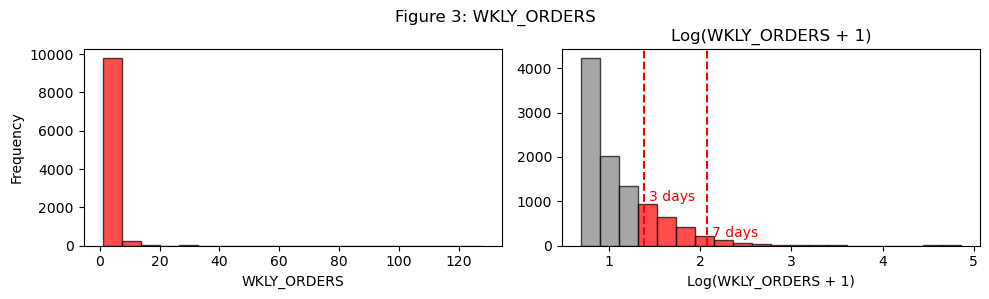

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def color_bins_above_threshold(ax, threshold):
    '''
    Input ax subplot for hist
    Input threshold value for determining signal (assumes ascending)
    
    Modifies patch coloring for signal
    '''
    # Calculate combined values
    bin_combined = [patch.get_x() + patch.get_width() for patch in ax.patches]

    # Find index where exceeds the threshold (else return end)
    index_to_color = next((i for i, value in enumerate(bin_combined) if value > threshold), len(bin_combined))

    # Color bins red from index onward
    for patch in ax.patches[index_to_color:]:
        patch.set_facecolor('red')

data = DDS['WKLY_ORDERS']

# Log values
log_3 = np.log(3 + 1)
log_7 = np.log(7 + 1)

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Left WKLY_ORDERS histogram
ax1.hist(data, bins=20, color='grey', edgecolor='black', alpha=0.7)

color_bins_above_threshold(ax1, 
                           threshold=log_3)

ax1.set(xlabel='WKLY_ORDERS', ylabel='Frequency')

# Title
num_figure += 1
fig.suptitle(f"Figure {num_figure}: WKLY_ORDERS")

# Right histogram with red bars for signal
ax2.hist(np.log(data + 1), bins=20, color='grey', edgecolor='black', alpha=0.7)

color_bins_above_threshold(ax2, 
                           threshold=log_3)
    
# Add lines and text
for val, text, y in [(log_3, "3 days", 1000), 
                     (log_7, "7 days", 200)]:
    ax2.axvline(val, color='red', linestyle='dashed')
    ax2.text(val + 0.05, y, text, color="red")

ax2.set(xlabel='Log(WKLY_ORDERS + 1)', title='Log(WKLY_ORDERS + 1)')


plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


<style>
.text_cell_render {
font-family: Times New Roman, serif;
}
</style>
### Missingness

Ultimately, I finished the last touches of preparing the dataset. Please see in Figure 2 the tidied dataset, `DDS`, with its moderate missingness:

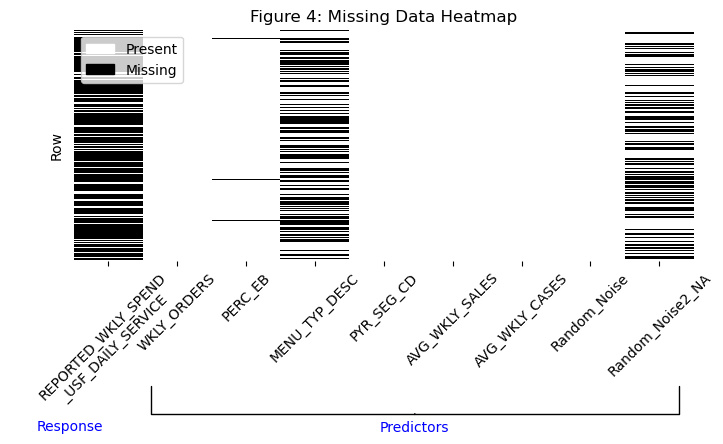

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import textwrap

# Missing data heatmap with annotations in 'figure pixels'
def plot_missing_data_heatmap(data, num_figure, response_variable_name):
    # Ensure the response variable is the first
    if response_variable_name in data.columns:
        data = data[[response_variable_name] + [col for col in data.columns if col != response_variable_name]]

    # Create missingness heatmap
    missing_data = data.isna()

    # Plot heatmap
    plt.figure(figsize=(8, 3))
    ax = sns.heatmap(missing_data, 
                    cbar=False, 
                    cmap="binary", 
                    xticklabels=True,
                    yticklabels=False)
    
    # Rotate x-labels, break long labels
    ax.set_xticklabels([textwrap.fill(label, 19) for label in data.columns], rotation=45)
    
    plt.ylabel("Row")
    plt.title(f"Figure {num_figure}: Missing Data Heatmap")

    # Add custom legend
    present_patch = mpatches.Patch(color='white', label='Present')
    missing_patch = mpatches.Patch(color='black', label='Missing')
    plt.legend(handles=[present_patch, missing_patch], loc='upper left')

    # Modify annotations to use 'figure pixels'
    response_x = data.columns.get_loc(response_variable_name)
    plt.annotate(
        "Response",
        xy=(50, 10),  # Position in 'figure pixels'
        color='blue',  # Text color
        xycoords='figure points',  # Coordinate system
        horizontalalignment='center'  # Center text
    )

    predictors_x = len(data.columns) / 2

    # Add bracket for "Predictors"
    ax.annotate('Predictors', 
                xy=(0.55, -0.65), 
                xytext=(0.55, -0.75), 
                color='blue',  # Text color
                xycoords='axes fraction', 
                ha='center', 
                va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=19.0, lengthB=2', lw=1.0))

    plt.show()

# Call the function with your data and specify the response variable name
num_figure += 1
plot_missing_data_heatmap(DDS, num_figure, 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE')


<style>
.text_cell_render {
font-family: Times New Roman, serif;
}
</style>
### Model-Choice

I chose a Decision Tree for maximum interpretability and ease of use in R; it was a simple, straightforward model to fine-tune hyperparameters for a mini-analysis rather than more complex models, and the results are far more interpretable to a broader audience than multiple linear regression. Furthermore, Decision Trees also use missingness remarkably well, which is present in significant rates ~50% (e.g., PERC_EB, MENU_TYP_DESC), contrasting with most models that must omit NA rows for the model-fitting. As such, and because Decision Trees feature-select automatically, I investigated this simple model: `Model`: `REPORTED_WKLY_SPEND_USF_DAILY_SERVICE` ~ .

However, using `Python`, getting the Decision Tree to work with missingness took several days to resolve! I struggled to make the `sklearn` library work as `R`'s `rpart` or `caret` did with passing in NAs, but to no avail. `sklearn` and `DecisionTreeRegressor` would always "ValueError" despite documentation saying it has missingness support, and that Decision Trees should have missingness support. Eventually, I stumbled on a programmer's custom code revamping the Decision Tree classes for incorporating missingness support at the cost of `sklearn`'s other features. This took me down a few rabbit holes, but ultimately, I got an answer nearly the same as in `R`.

In [20]:
# GitHub: Custom native-NA handling Decision Tree (Not available in sklearn otherwise in Python)
# https://insidelearningmachines.com/decision_trees_handle_missing_values/

# imports
from __future__ import annotations
from typing import Tuple
from abc import ABC,abstractmethod
from scipy import stats
from random import choices
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification,make_regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,mean_squared_error,mean_absolute_error

class Node(object):
    """
    Class to define & control tree nodes
    """
    
    def __init__(self) -> None:
        """
        Initializer for a Node class instance
        """
        self.__split    = None
        self.__feature  = None
        self.__left     = None
        self.__right    = None
        self.leaf_value = None

    def set_params(self, split: float, feature: int) -> None:
        """
        Set the split & feature parameters for this node
        
        Input:
            split   -> value to split feature on
            feature -> index of feature to be used in splitting 
        """
        self.__split   = split
        self.__feature = feature
        
    def get_params(self) -> Tuple[float,int]:
        """
        Get the split & feature parameters for this node
        
        Output:
            Tuple containing (split,feature) pair
        """
        return(self.__split, self.__feature)    
        
    def set_children(self, left: Node, right: Node) -> None:
        """
        Set the left/right child nodes for the current node
        
        Inputs:
            left  -> LHS child node
            right -> RHS child node
        """
        self.__left  = left
        self.__right = right
        
    def get_left_node(self) -> Node:
        """
        Get the left child node
        
        Output:
            LHS child node
        """
        return(self.__left)
    
    def get_right_node(self) -> Node:
        """
        Get the RHS child node
        
        Output:
            RHS child node
        """
        return(self.__right)

##--------------------------------------------- 
class DecisionTree(ABC):
    """
    Base class to encompass the CART algorithm
    """
    
    def __init__(self, max_depth: int=None, min_samples_split: int=2, nans_go_right=True) -> None:
        """
        Initializer
        
        Inputs:
            max_depth         -> maximum depth the tree can grow
            min_samples_split -> minimum number of samples required to split a node
            nans_go_right     -> boolean to determine where NaN values in predictors are allocated
        """
        self.tree              = None
        self.max_depth         = max_depth
        self.min_samples_split = min_samples_split
        self.nans_go_right     = nans_go_right
        
    @abstractmethod
    def _impurity(self, D: np.array) -> None:
        """
        Protected function to define the impurity
        """
        pass
        
    @abstractmethod
    def _leaf_value(self, D: np.array) -> None:
        """
        Protected function to compute the value at a leaf node
        """
        pass
        
    def __split_right(self, feature_col: np.array, split_point: float) -> np.array:
        """
        Private function to determine which elements in the feature column go to the child right node
        
        Inputs:
            feature_col -> feature column to analyse
            split_point -> split point for the feature column
        Outputs:
            numpy array of boolean values
        """
        return (feature_col > split_point) | (np.isnan(feature_col) & self.nans_go_right)
 
    def __split_left(self, feature_col: np.array, split_point: float) -> np.array:
        """
        Private function to determine which elements in the feature column go to the child left node
        
        Inputs:
            feature_col -> feature column to analyse
            split_point -> split point for the feature column
        Outputs:
            numpy array of boolean values
        """
        return (feature_col <= split_point) | (np.isnan(feature_col) & (not self.nans_go_right))

    def __grow(self, node: Node, D: np.array, level: int) -> None:
        """
        Private recursive function to grow the tree during training
        
        Inputs:
            node  -> input tree node
            D     -> sample of data at node 
            level -> depth level in the tree for node
        """
        # are we in a leaf node?
        depth = (self.max_depth is None) or (self.max_depth >= (level+1))
        msamp = (self.min_samples_split <= D.shape[0])
        cls   = D[:,-1]
        n_cls = np.unique(cls[~np.isnan(cls)]).shape[0] != 1
        
        # not a leaf node
        if depth and msamp and n_cls:
        
            # initialize the function parameters
            ip_node = None
            feature = None
            split   = None
            left_D  = None
            right_D = None
            # iterate through the possible feature/split combinations
            for f in range(D.shape[1]-1):
                f_values = D[:,f]
                for s in np.unique(f_values[~np.isnan(f_values)]):
                    # for the current (f,s) combination, split the dataset
                    D_l = D[self.__split_left(D[:,f],s)]
                    D_r = D[self.__split_right(D[:,f],s)]
                    # ensure we have non-empty arrays
                    if D_l.size and D_r.size:
                        # calculate the impurity
                        ip  = (D_l.shape[0]/D.shape[0])*self._impurity(D_l) + (D_r.shape[0]/D.shape[0])*self._impurity(D_r)
                        # now update the impurity and choice of (f,s)
                        if (ip_node is None) or (ip < ip_node):
                            ip_node = ip
                            feature = f
                            split   = s
                            left_D  = D_l
                            right_D = D_r
            # set the current node's parameters
            node.set_params(split,feature)
            # declare child nodes
            left_node  = Node()
            right_node = Node()
            node.set_children(left_node,right_node)
            # investigate child nodes
            self.__grow(node.get_left_node(),left_D,level+1)
            self.__grow(node.get_right_node(),right_D,level+1)
                        
        # is a leaf node
        else:
            
            # set the node value & return
            node.leaf_value = self._leaf_value(D)
            return
     
    def __traverse(self, node: Node, Xrow: np.array) -> int | float:
        """
        Private recursive function to traverse the (trained) tree
        
        Inputs:
            node -> current node in the tree
            Xrow -> data sample being considered
        Output:
            leaf value corresponding to Xrow
        """        
        # check if we're in a leaf node?
        if node.leaf_value is None:
            # get parameters at the node
            (s,f) = node.get_params()
            # decide to go left or right?
            if (self.__split_left(Xrow[f],s)):
                return(self.__traverse(node.get_left_node(),Xrow))
            else:
                # note nan's in Xrow will go right
                return(self.__traverse(node.get_right_node(),Xrow))
        else:
            # return the leaf value
            return(node.leaf_value)
    
    def train(self, Xin: np.array, Yin: np.array) -> None:
        """
        Train the CART model
        
        Inputs:
            Xin -> input set of predictor features
            Yin -> input set of labels
        """        
        # prepare the input data
        D            = np.concatenate((Xin,Yin.reshape(-1,1)),axis=1)
        D[D == None] = np.nan
        D            = D.astype('float64')
        # set the root node of the tree
        self.tree = Node()
        # build the tree
        self.__grow(self.tree,D,1)
        
    def predict(self, Xin: np.array) -> np.array:
        """
        Make predictions from the trained CART model
        
        Input:
            Xin -> input set of predictor features
        Output:
            array of prediction values
        """
        # prepare the input data
        Xin[Xin == None] = np.nan
        Xin              = Xin.astype('float64')
        # iterate through the rows of Xin
        p = []
        for r in range(Xin.shape[0]):
            p.append(self.__traverse(self.tree,Xin[r,:]))
        # return predictions
        return(np.array(p).flatten())

##--------------------------------------------- 
class DecisionTreeClassifier(DecisionTree):
    """
    Decision Tree Classifier
    """
    
    def __init__(self, max_depth: int=None, min_samples_split: int=2, nans_go_right=True, loss: str='gini') -> None:
        """
        Initializer
        
        Inputs:
            max_depth         -> maximum depth the tree can grow
            min_samples_split -> minimum number of samples required to split a node
            nans_go_right     -> boolean to determine where NaN values in predictors are allocated
            loss              -> loss function to use during training
        """
        DecisionTree.__init__(self,max_depth,min_samples_split,nans_go_right)
        self.loss = loss   
    
    def __gini(self, D: np.array) -> float:
        """
        Private function to define the gini impurity
        
        Input:
            D -> data to compute the gini impurity over
        Output:
            Gini impurity for D
        """        
        # initialize the output
        G = 0
        # iterate through the unique classes
        cls = D[:,-1]
        for c in np.unique(cls[~np.isnan(cls)]):
            # compute p for the current c
            p = D[D[:,-1]==c].shape[0]/D.shape[0]
            # compute term for the current c
            G += p*(1-p)
        # return gini impurity
        return(G)
    
    def __entropy(self, D: np.array) -> float:
        """
        Private function to define the shannon entropy
        
        Input:
            D -> data to compute the shannon entropy over
        Output:
            Shannon entropy for D
        """        
        # initialize the output
        H = 0
        # iterate through the unique classes
        cls = D[:,-1]
        for c in np.unique(cls[~np.isnan(cls)]):
            # compute p for the current c
            p = D[D[:,-1]==c].shape[0]/D.shape[0]
            # compute term for the current c
            H -= p*np.log2(p)
        # return entropy
        return(H)
    
    def _impurity(self, D: np.array) -> float:
        """
        Protected function to define the impurity
        
        Input:
            D -> data to compute the impurity metric over
        Output:
            Impurity metric for D        
        """        
        # use the selected loss function to calculate the node impurity
        ip = None
        if self.loss == 'gini':
            ip = self.__gini(D)
        elif self.loss == 'entropy':
            ip = self.__entropy(D)
        # return results
        return(ip)
    
    def _leaf_value(self, D: np.array) -> int:
        """
        Protected function to compute the value at a leaf node
        
        Input:
            D -> data to compute the leaf value
        Output:
            Mode of D         
        """        
        return(stats.mode(D[:,-1],keepdims=False,nan_policy='omit')[0])

##---------------------------------------------     
class DecisionTreeRegressor(DecisionTree):
    """
    Decision Tree Regressor
    """
    
    def __init__(self, max_depth: int=None, min_samples_split: int=2, nans_go_right=True, loss: str='mse') -> None:
        """
        Initializer
        
        Inputs:
            max_depth         -> maximum depth the tree can grow
            min_samples_split -> minimum number of samples required to split a node
            nans_go_right     -> boolean to determine where NaN values in predictors are allocated
            loss              -> loss function to use during training
        """        
        DecisionTree.__init__(self,max_depth,min_samples_split,nans_go_right)
        self.loss = loss   
    
    def __mse(self, D: np.array) -> float:
        """
        Private function to define the mean squared error
        
        Input:
            D -> data to compute the MSE over
        Output:
            Mean squared error over D
        """
        # compute the mean target for the node
        y_m = np.mean(D[:,-1],where=~np.isnan(D[:,-1]))
        # compute the mean squared error wrt the mean
        E = np.sum((D[:,-1] - y_m)**2,where=~np.isnan(D[:,-1]))/D.shape[0]
        # return mse
        return(E)
    
    def __mae(self, D: np.array) -> float:
        """
        Private function to define the mean absolute error
        
        Input:
            D -> data to compute the MAE over
        Output:
            Mean absolute error over D
        """
        # compute the mean target for the node
        y_m = np.mean(D[:,-1],where=~np.isnan(D[:,-1]))
        # compute the mean absolute error wrt the mean
        E = np.sum(np.abs(D[:,-1] - y_m),where=~np.isnan(D[:,-1]))/D.shape[0]
        # return mae
        return(E)
    
    def _impurity(self, D: np.array) -> float:
        """
        Protected function to define the impurity
        
        Input:
            D -> data to compute the impurity metric over
        Output:
            Impurity metric for D        
        """            
        # use the selected loss function to calculate the node impurity
        ip = None
        if self.loss == 'mse':
            ip = self.__mse(D)
        elif self.loss == 'mae':
            ip = self.__mae(D)
        # return results
        return(ip)
    
    def _leaf_value(self, D: np.array) -> float:
        """
        Protected function to compute the value at a leaf node
        
        Input:
            D -> data to compute the leaf value
        Output:
            Mean of D           
        """
        return(np.mean(D[:,-1],where=~np.isnan(D[:,-1])))

<style>
.text_cell_render {
font-family: Times New Roman, serif;
}
</style>
### Cross-Validations

For model-fitting in `Python`, to perform a 10-fold, single cross-validation on a training data subset (i.e., customers that were in the survey and reported weekly daily services spending) because the `DecisionTreeRegressor` was custom, instead of using `sklearn` and its popular `GridSearch`, I employed a hyperparameter tuning cross-validation manually.

For `Python`'s Decision Tree model-fitting, and because of the custom functions, I could not use complexity parameter or cp. Still, I could tune it comparably: (1) max_depths - the max_depths determines the Decision Tree's number of split levels. Between trial and error, a depth of 2 to 3 was appropriate; (2) min_samples_splits - the minimum samples per split is how many samples guarantee a split; otherwise, it would not be explored. The higher the threshold, the less missingness would affect the prediction.

Note: for machine learning compared to `R`, to use `Python`, I had to do a few additional steps: (1) one-hot encode categorical variables (e.g., factor); (2) convert `pandas` dataframes to `numpy` arrays, thus dropping feature names from the column.

In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Data Preparation
response_var = 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE'
predictor_vars = [col for col in DDS.columns]
data = DDS.dropna(subset=[response_var])
Y = data[response_var].values
X = pd.get_dummies(data[predictor_vars], dummy_na=True).values # one-hot encode, dummy NA required

In [22]:
# import numpy as np
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import KFold
# import time

# # Hyperparameter Grid
# max_depths = [2, 3]
# min_samples_splits = list(range(2, 100, 30))

# # Initialize Best Hyperparameters and RMSE
# best_max_depth = None
# best_min_samples_split = None
# best_rmse = float('inf')

# # Perform 10-fold Cross-Validation
# kf = KFold(n_splits=10, shuffle=True, random_state=1)

# # Measure the execution time
# start_time = time.time()

# for max_depth in max_depths:
#     for min_samples_split in min_samples_splits:
#         rmse_scores = []
#         for train_idx, val_idx in kf.split(X):
#             X_train, X_val = X[train_idx], X[val_idx]
#             y_train, y_val = Y[train_idx], Y[val_idx]
            
#             # Train the Decision Tree
#             decision_tree = DecisionTreeRegressor(max_depth=max_depth, 
#                                                   min_samples_split=min_samples_split, 
#                                                   loss='mse')
#             decision_tree.train(X_train, y_train)
            
#             # Make Predictions
#             y_pred = decision_tree.predict(X_val)
            
#             # Calculate RMSE
#             rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#             rmse_scores.append(rmse)
        
#         # Calculate Mean RMSE for Current Hyperparameters
#         mean_rmse = np.mean(rmse_scores)
        
#         # Update Best Hyperparameters if Lower Mean RMSE
#         if mean_rmse < best_rmse:
#             best_max_depth = max_depth
#             best_min_samples_split = min_samples_split
#             best_rmse = mean_rmse

# # Calculate the execution time
# end_time = time.time()
# execution_time = end_time - start_time

# # Print the best hyperparameters and execution time
# #print(f"Best Max Depth: {best_max_depth}")
# #print(f"Best Min Samples Split: {best_min_samples_split}")
# #print(f"Best RMSE: {best_rmse}")
# #print(f"Execution Time: {execution_time/60:.2f} minutes")

# #Best Max Depth: 3
# #Best Min Samples Split: 2
# #Best RMSE: 3266.2862899241527
# #Execution Time: 9.16 minutes


In [23]:
from sklearn.metrics import mean_squared_error

random.seed(1)

# Train the Model with Best Hyperparameters
DecisionTree = DecisionTreeRegressor(max_depth=3, 
                                           min_samples_split=2, 
                                           loss='mse')
DecisionTree.train(X, Y)

# Make Predictions with the Best Model
#y_predictions = DecisionTree.predict(X) 
#y_pred = DecisionTree.predict(X)

# Calculate RMSE on test data
#rmse = np.sqrt(mean_squared_error(Y, y_predictions))
#print("RMSE on test data:", round(rmse,0))


<style>
.text_cell_render {
font-family: Times New Roman, serif;
}
</style>
After 10-fold cross-validation, we have our best Decision Tree model after plugging in the `best_max_depth` (e.g., 3) and `best_min_samples_split` (e.g., 2) and training it to the entire training dataset.

The prediction accuracy of the Decision Tree model was 3266 root mean square error (i.e., log-transformed to 8). Surprisingly, `Python`'s cross-validation showed its custom model had a better prediction ability for a regression Decision Tree than in `R` (e.g., RMSE of 3200s versus 6000s).

See the following figure of the response variable distribution for the context of why the model's prediction is reasonable:

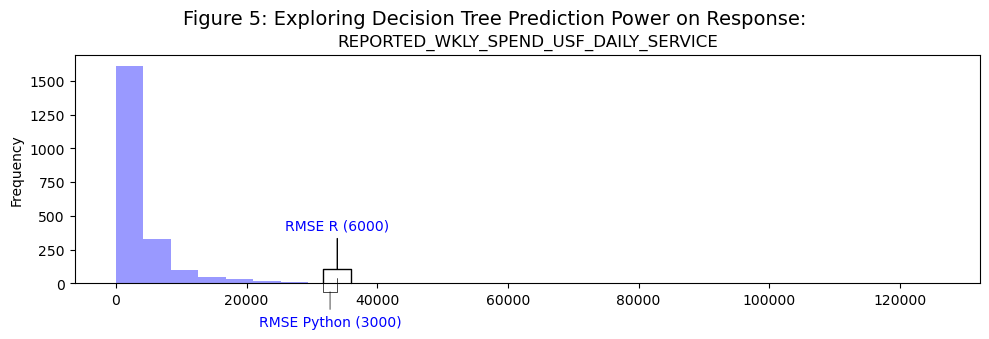

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Original data
label_data = DDS['REPORTED_WKLY_SPEND_USF_DAILY_SERVICE']

# Create a single plot
fig, axes = plt.subplots(figsize=(10, 3.5))

# Original histogram
axes.hist(label_data, bins=30, color='blue', alpha=0.4)
axes.set(xlabel='', ylabel='Frequency')
axes.set_title('Original')

# Transformed histogram
transformed_label_data = np.log(label_data+1)
axes.hist(transformed_label_data, bins=30, color='green', alpha=0.4)
axes.set_xlabel('')
axes.set_title('REPORTED_WKLY_SPEND_USF_DAILY_SERVICE')

# Add brackets for RMSE: R and RMSE: Python
x_diff = 0.02 + 0.25
x_R_diff = 0.02
x_Python_diff = 0.012
axes.annotate('RMSE R (6000)', 
            xy=(x_diff+x_R_diff, 0.05), 
            xytext=(x_diff+x_R_diff, 0.22), 
            color='blue',  # Text color
            xycoords='axes fraction', 
            ha='center', 
            va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1, lengthB=1', lw=1.0))
axes.annotate('RMSE Python (3000)', 
            xy=(x_diff+x_Python_diff, -0.025), 
            xytext=(x_diff+x_Python_diff, -0.2), 
            color='blue',  # Text color
            xycoords='axes fraction', 
            ha='center', 
            va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=0.5, lengthB=1', lw=0.5))

num_figure += 1
# Add a title to the entire figure
fig.suptitle(f'Figure {num_figure}: Exploring Decision Tree Prediction Power on Response:', fontsize=14)

# Show the figure
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


<style>
.text_cell_render {
font-family: Times New Roman, serif;
}
</style>
Unfortunately, as a result of needing a custom `DecisionTreeRegressor` and subsidiary `Python` classes to handle missingness, feature importance (i.e., variable importance) was unavailable to use for assessing the `Python` model's predictor variables importance overall. Likewise, for Decision Tree visualization, the custom function dictated that I had to build a network graph using similar work done for Decision Tree diagrams.

Nevertheless, here was the best model using a Decision Tree handling missingness in `Python`:

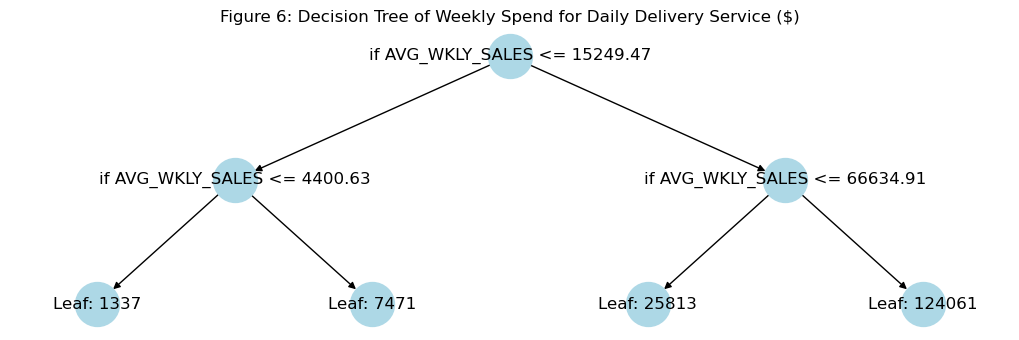

In [25]:
import networkx as nx
import matplotlib.pyplot as plt

# Create NetworkX graph
tree_graph = nx.DiGraph()

# Set rank direction
tree_graph.graph['graph'] = {'rankdir': 'TB'}

def build_tree_graph(node, parent=None):
    if node is None:
        return

    tree_graph.add_node(node)  # Add node

    if parent is not None:
        tree_graph.add_edge(parent, node)  # Add edge

    if node.leaf_value is not None:
        tree_graph.nodes[node]['label'] = f"Leaf: {node.leaf_value:.0f}"  # Label leaf
    else:
        split, feature = node.get_params()
        tree_graph.nodes[node]['label'] = f"if {feature} <= {split:.2f}"  # Label non-leaf

    left_node, right_node = node.get_left_node(), node.get_right_node()  # Left and right nodes

    if left_node is not None:
        build_tree_graph(left_node, node)  # Build left

    if right_node is not None:
        build_tree_graph(right_node, node)  # Build right

def create_hierarchy_pos(graph, 
                        root=None, 
                        width=1., 
                        vert_gap=0.2, 
                        vert_loc=0, 
                        xcenter=0.5):
    #if not nx.is_tree(graph):
     #   raise TypeError('Cannot use hierarchy_pos on non-tree graph')

    if root is None:
        if isinstance(graph, nx.DiGraph):
            root = next(iter(nx.topological_sort(graph)))  # Default root for directed graphs
        else:
            root = list(graph.nodes)[0]  # Default root for undirected graphs

    def _create_hierarchy_pos(graph, 
                              root, 
                              width=1., 
                              vert_gap=0.2, 
                              vert_loc=0, 
                              xcenter=0.5, 
                              pos=None, 
                              parent=None):
        if pos is None:
            pos = {root: (xcenter, vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(graph.neighbors(root))
        if not isinstance(graph, nx.DiGraph) and parent is not None:
            children.remove(parent)
        if len(children) != 0:
            dx = width / len(children)
            nextx = xcenter - width / 2 - dx / 2
            for child in children:
                nextx += dx
                pos = _create_hierarchy_pos(graph, 
                                            child, 
                                            width=dx, 
                                            vert_gap=vert_gap, 
                                            vert_loc=vert_loc - vert_gap, 
                                            xcenter=nextx, 
                                            pos=pos, 
                                            parent=root)
        return pos

    return _create_hierarchy_pos(graph, root, width, vert_gap, vert_loc, xcenter)

def replace_feature_numbers_with_names(labels, feature_names):
    '''
    {<__main__.Node at 0x17f9433e640>: 'if 0 <= 3.24',
 <__main__.Node at 0x17f94357c40>: 'Leaf: 2173',
 <__main__.Node at 0x17f94357d00>: 'Leaf: 9068'}
    
    
    <__main__.Node object at 0x0000017F9433E640>: if WKLY_ORDERS <= 3.24
<__main__.Node object at 0x0000017F94357C40>: Leaf: 2173
<__main__.Node object at 0x0000017F94357D00>: Leaf: 9068
    '''
    
    # Map numbers to names
    feature_mapping = {str(i): feature_names[i] for i in range(len(feature_names))}
    
    # Replace "if NUMBER <=.." with "if FEATURE_NAME <=.."
    updated_labels = {node: ' '.join([feature_mapping.get(part, part) for part in label.split()]) for node, label in labels.items()}
    
    return updated_labels 


# Example usage:
root_node = DecisionTree.tree
build_tree_graph(node=root_node)

labels_0 = {node: tree_graph.nodes[node]['label'] for node in tree_graph.nodes()}  # Extract labels
labels = replace_feature_numbers_with_names(labels_0, predictor_vars) # Add feature names

pos = create_hierarchy_pos(tree_graph, root_node)  # Use create_hierarchy_pos with the correct root node
plt.figure(figsize=(10, 3)) # change size
nx.draw(tree_graph, 
        pos=pos, 
        labels=labels, 
        node_size=1000, 
        node_color='lightblue', 
        font_size=12)
# Title
num_figure += 1
plt.title(f"Figure {num_figure}: Decision Tree of Weekly Spend for Daily Delivery Service ($)")

plt.show()


<style>
.text_cell_render {
font-family: Times New Roman, serif;
}
</style>
Figure 4 reveals the following insights:

- The `Python` analysis emphasizes the importance of the `WKLY_SALES` variable for predicting `REPORTED_WKLY_SPEND_USF_DAILY_SERVICE`. This aligns with the expectation that larger customers have a stronger association with US Foods due to their increased business volume. This reflects the standard business practice of favoring existing partners.
- Combined with the better cross-validation and the lack of `Random_*` noise variables popping into the model, I believe this is a good signal (e.g., no over-fitting) for `Python`'s Decision Tree regression. 

### Discussion

In comparing `R` and `Python`, `R` provided a reasonably simple and interpretable solution. It identified a critical threshold, `WKLY_ORDERS` <= 3.2, effectively categorizing customers into low and high-spenders for daily delivery service. This insight suggests that focusing on customers with more than three days of `WKLY_ORDERS` could be a strategic approach. Additionally, it highlighted that `WKLY_ORDERS` significantly outweighed the importance of `WKLY_SALES`. I also believe `R` offered a much better markdown option than `Python` (e.g., references in BibTeX with citations, more straightforward templates, and formatting document knitting).

On the other hand, `Python` produced a more accurate predictive regression model but lacked in-depth explanations. The specific variable importance and the reasons behind the model changes needed more transparency. This raises questions about the consistency and interpretability of the results. To enhance the analysis, another idea would be to consider the problem as a classification task, differentiating between "High" and "Low" Daily Delivery Spenders; it might offer a fresh perspective.

Despite the differences, working in `Python` proved to be highly informative. Building a Decision Tree from scratch enhanced understanding, inspiring the potential use of Decision Tree classes for future projects (e.g., Capstone: I could build off this Decision Tree handling missingness to optimally grow the tree with linear programming rather than Greedy algorithm). It's evident that both `R` and `Python` have their strengths, and qualifications should be based on more than just expertise in only one of the languages. `R` excels for quick exploratory data analysis, statistical tasks, and strict deadlines. In contrast, `Python` offers flexibility and a low-level approach, potentially leading to more extensive development. Planning in `R` is straightforward, while `Python`'s versatility may introduce unexpected complexities in simple problems. Both languages have merits, and their suitability depends on the project requirements.

-----------------------------------------------

Sources:

1. https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209#29597209/
2. https://insidelearningmachines.com/decision_trees_handle_missing_values/

-------------------------------------